# GIOELE MIGNO 1795826

# HOW VECTORIZATION AND CLASSIFICATION ARE PERFORMED

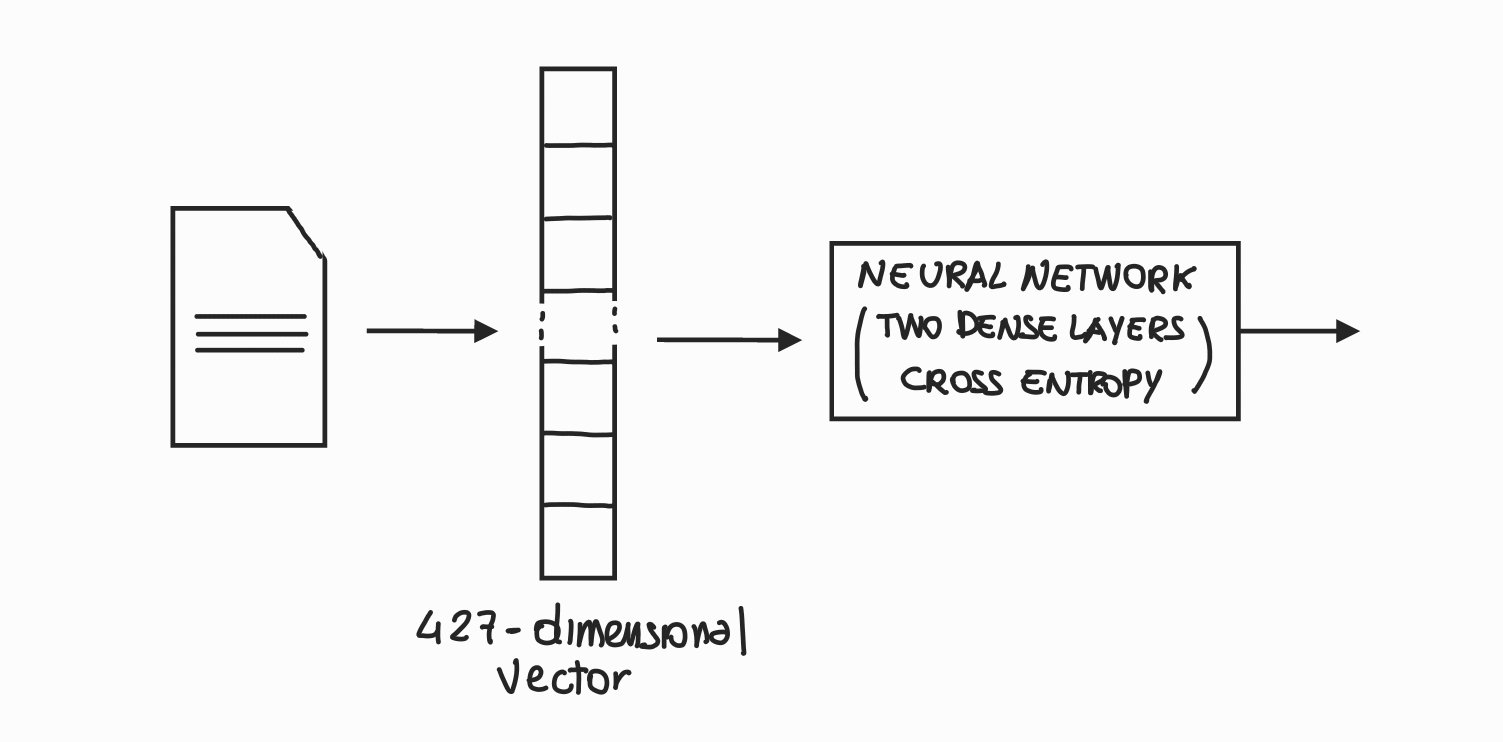

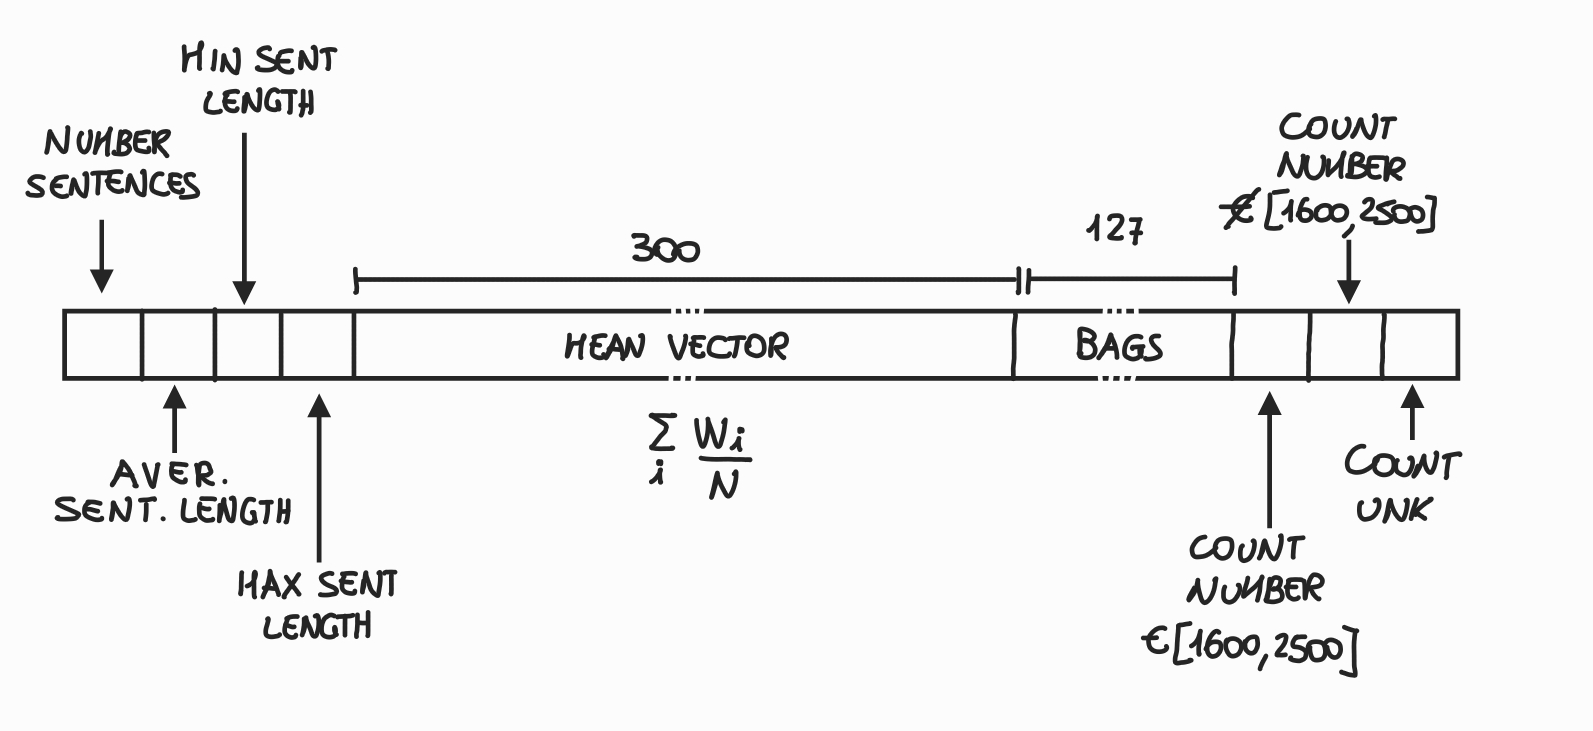

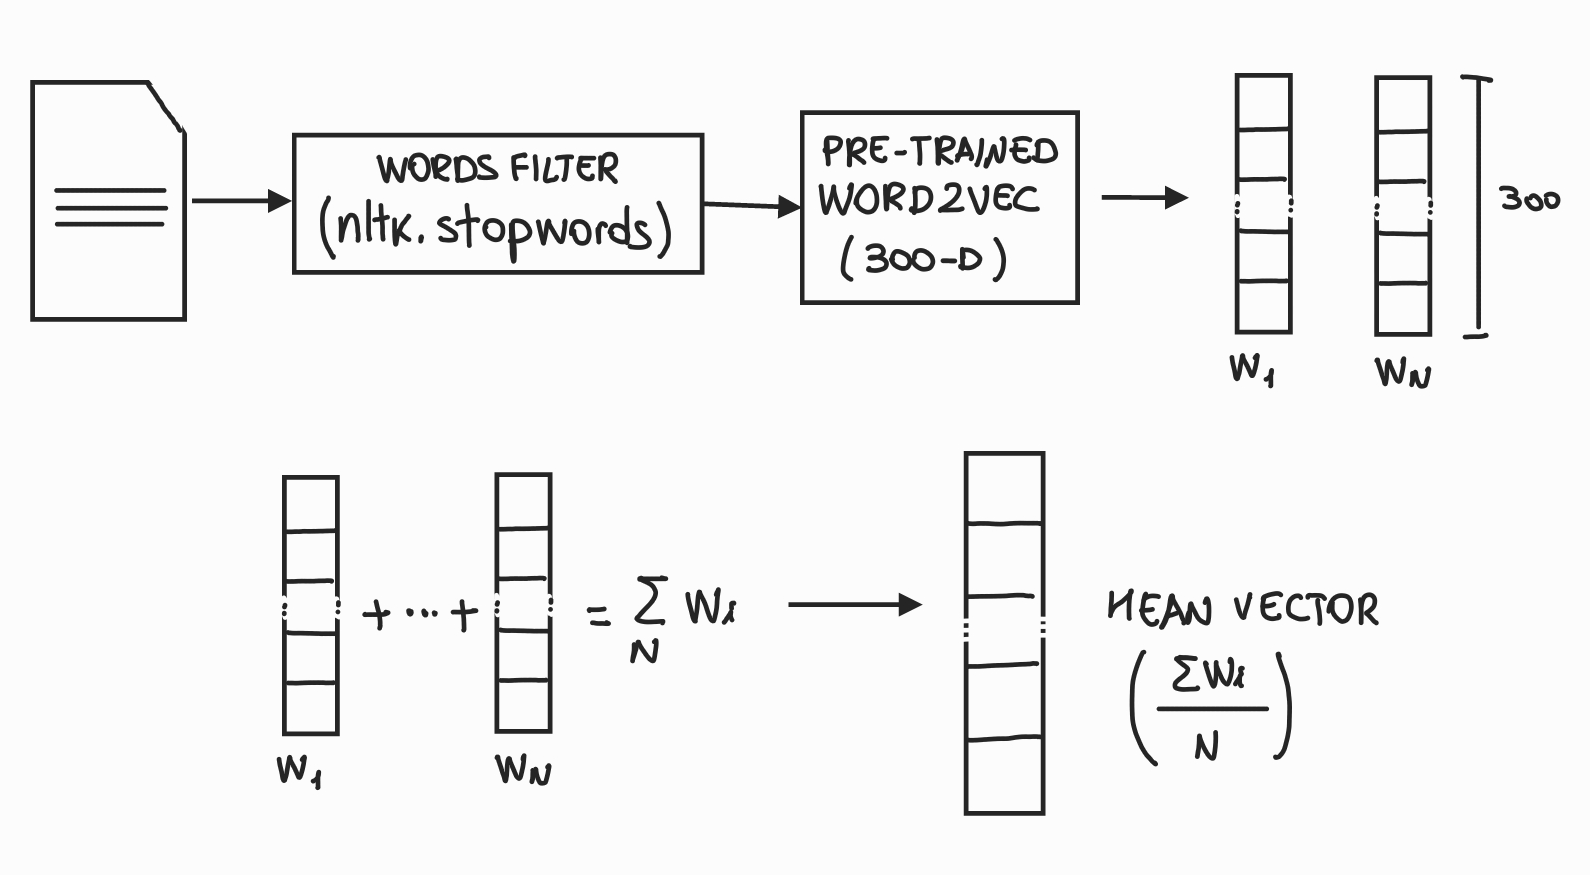

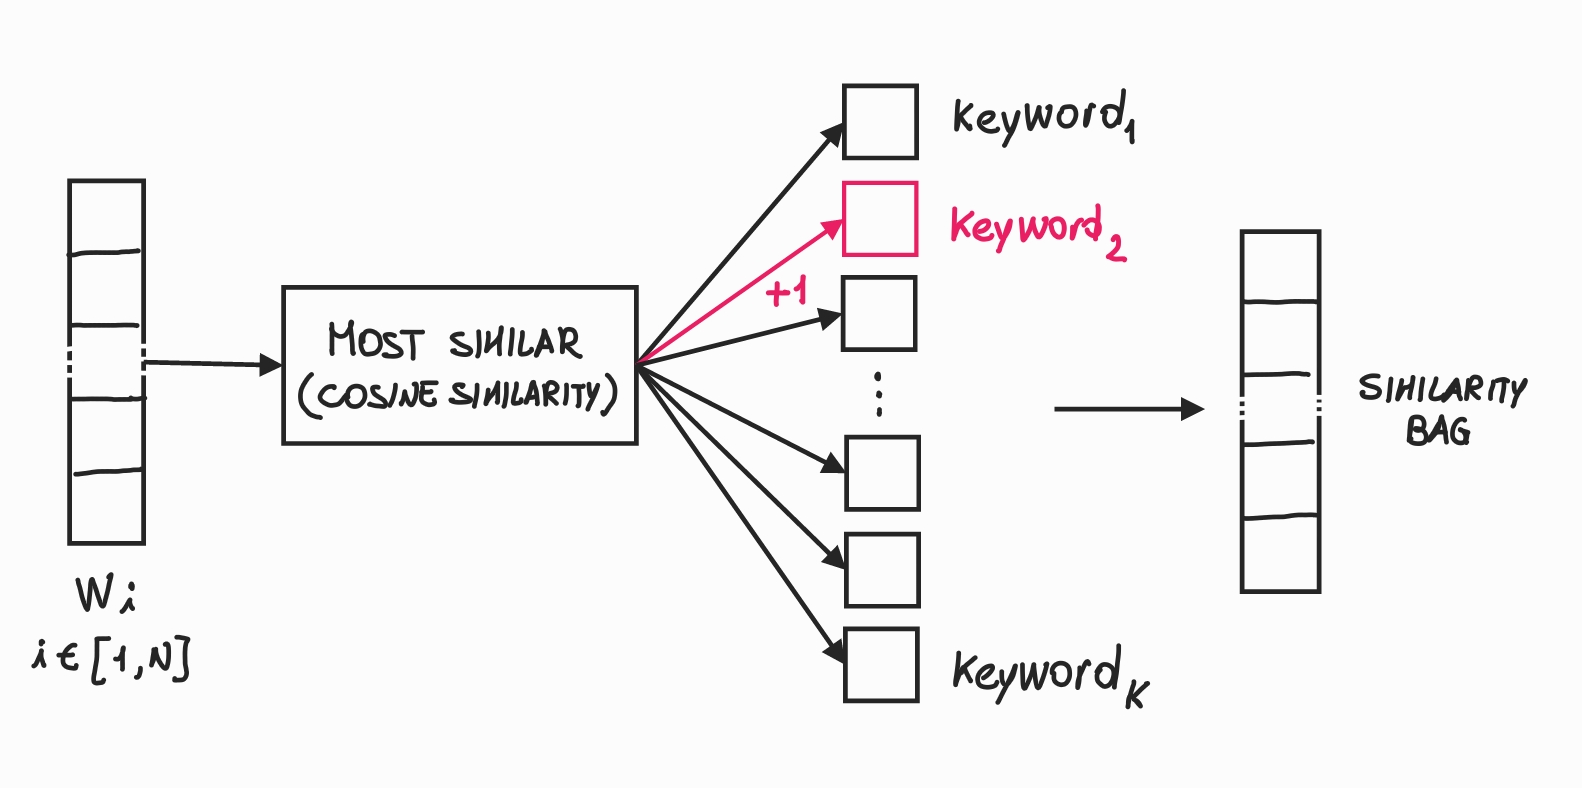

# SETUP

In [73]:
GLOBAL_SETTING={
    'RANDOM_SEED': 47,
    'BATCH_SIZE_TRAIN': 32,
    'BATCH_SIZE_VAL': 32, 
}

### MOUNT

In [74]:
from google.colab import drive

MOUNT_POINT = '/content/gdrive' 
drive.mount(MOUNT_POINT,  force_remount=True)
MOUNT_POINT += "/My Drive"

Mounted at /content/gdrive


### CHECK GPU ASSIGNED

In [75]:
!nvidia-smi

Sun Mar 20 18:34:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   1342MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### SETUP FOLDERS AND FILES

In [76]:
import os 

DIR_ROOT = os.path.join(MOUNT_POINT, "5.2/NLP/01_BONUS")

In [77]:
DIR_PWD = os.path.join(DIR_ROOT, "NOTEBOOKS")
DIR_CACHE = os.path.join(DIR_PWD, "CACHE")

DIR_STUDIES = os.path.join(DIR_ROOT, "STUDIES")
DIR_FINAL = os.path.join(DIR_ROOT, "FINAL")
DIR_RESOURCES = os.path.join(DIR_ROOT, "RESOURCES")
DIR_OUTPUT = os.path.join(DIR_ROOT, "OUTPUT")

In [78]:
DIR_DATASET = os.path.join(DIR_RESOURCES, "nlp_2022-bonus_exercise_1/data")

FILE_TRAIN = os.path.join(DIR_DATASET, "train.jsonl")  
FILE_VAL = os.path.join(DIR_DATASET, "dev.jsonl")
FILE_TEST = os.path.join(DIR_DATASET, "test.jsonl")

#### Cached files

In [79]:
GENSIM_MODEL_NAME = "word2vec-google-news-300"

In [80]:
CACHE_FILE_GENSIM_MODEL = os.path.join(DIR_CACHE, GENSIM_MODEL_NAME + ".pickle")

In [81]:
CACHE_FILE_TRAIN_SET = os.path.join(DIR_CACHE, 'training_set.pickle')
CACHE_FILE_VAL_SET = os.path.join(DIR_CACHE, 'val_set.pickle')

#### External resources files

In [82]:
KEYWORD_FILE = os.path.join(DIR_RESOURCES, 'keywords.txt')

# IMPORT

In [83]:
import datetime

In [84]:
import json
import os
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [85]:
# used for hyperparameters tuning
!pip install optuna > /dev/null
import optuna

In [86]:
# for cute iteration bars (during training etc.)
from tqdm.auto import tqdm
from typing import *

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [88]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
# torch
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

# SET RANDOM SEED

In [90]:
torch.manual_seed(GLOBAL_SETTING['RANDOM_SEED'])

# WORD2VEC MODEL

In [91]:
import gensim.downloader
if not os.path.exists(CACHE_FILE_GENSIM_MODEL):
  word2vec = gensim.downloader.load(GENSIM_MODEL_NAME)
  with open(CACHE_FILE_GENSIM_MODEL, 'wb') as f:
    pickle.dump(word2vec, f)
else:
  with open(CACHE_FILE_GENSIM_MODEL, 'rb') as f:
    word2vec = pickle.load(f)

In [92]:
def word_to_vec(word):
  res =  None
  if word in word2vec.vocab:
    res = word2vec.get_vector(word)
  return res

In [93]:
def cosine_similarity(vec_0, vec_1) -> float:
  dot_product = np.dot(vec_0, vec_1)
  norms = np.linalg.norm(vec_0) * np.linalg.norm(vec_1)
  return dot_product / norms

def word_similarity(word_1: str, word_2: str) -> float:
  vec_1 = word_to_vec(word_1)
  vec_2 = word_to_vec(word_2)
  if vec_1 is None or vec_2 is None:
    return None
  else:
    return cosine_similarity(vec_1, vec_2)

In [94]:
word_similarity("dog", "cat")

0.76094574

In [95]:
word_similarity("dog", "person")

0.3113351

In [96]:
# unknow words are ignored:
print(word_similarity("dog", "hhhjj"))

None


In [97]:
                                                               # Callable[[Arg1Type, Arg2Type], ReturnType].
def get_most_similar_word(word_in: str, keywords: List[str], eval_f: Callable[[str, str], float]) -> str:
  if word_in in keywords:
    return word_in  
  else:  
    max_similarity = 0.0
    most_similar = word_in

    for word in keywords:
      eval = eval_f(word_in, word)
      if eval is None:
        return None
      if eval > max_similarity:
        max_similarity = eval
        most_similar = word
        #print(word)
        #print(eval)
        #print('---')
    return most_similar  

In [98]:
get_most_similar_word("france", ["person", "cat", "italy"], word_similarity)

'italy'

In [99]:
get_most_similar_word("dog", ["person", "cat", "italy"], word_similarity)

'cat'

In [100]:
get_most_similar_word("cat", ["person", "cat", "italy"], word_similarity)

'cat'

In [101]:
print(get_most_similar_word("gfgfghhj", ["person", "cat", "italy"], word_similarity))

None


# DATASET

In [102]:
# FROM NLP NOTEBOOK #2
def tokenize_line(line, pattern='\W'):
    """Tokenizes a single line."""
    return [word.lower() for word in re.split(pattern, line.lower()) if word]

## DATASET ANALYSIS

Get most common words

In [103]:
if False:
  classes = {
      'business': Counter(),
      'world': Counter(),
      'culture/arts': Counter(),
      'sci/tech': Counter(),
      'sports': Counter(),
      'wellness': Counter(),
      'politics': Counter(),
      'food/drink': Counter(),
      'environment': Counter(),
      'media': Counter(),
      'crime': Counter(),
      'entertainment': Counter(),
      'education': Counter(),
      'home/living': Counter(),
      'religion': Counter()
  }

  with open(FILE_TRAIN) as f:
    for line in f:
      loaded = json.loads(line)
      text_in = loaded['text']
      label = loaded['label']
      text_tokenized = tokenize_line(text_in)
      words_to_filer = stopwords.words('english')
      text_token_filtered = [word for word in text_tokenized if not word in words_to_filer]

      for word in text_token_filtered:
        classes[label][word] += 1


In [104]:
if False:
  for key in classes.keys():
    print("---------------------")
    print(key)
    print("---------------------")
    mc = classes[key].most_common(20)
    for elem in mc:
      word = elem[0]
      print(word) 
    print("**************************************")

I've chosen several keywords from previous output and I've saved them in KEYWORD_FILE

In [105]:
keywords = []
with open(KEYWORD_FILE, 'r') as f:
    for line in f:
        word = line.strip()
        if word != '':
            keywords.append(word)
keywords[:10]

['said',
 'oil',
 'reuters',
 'company',
 'prices',
 'year',
 'inc',
 'percent',
 'million',
 'billion']

Check keywords vectorizable

In [106]:
def check_keywords(keywords: str):
  unknown_keyw = []
  for word in keywords:
    if word_to_vec(word) is None:
      if not word in unknown_keyw:
        unknown_keyw.append(word)
  for word in unknown_keyw:
    print("unknown word! ---" + word + "---")

In [107]:
check_keywords(keywords)

Remove unknown keywords (if present)

In [108]:
keywords = [word for word in keywords if not word_to_vec(word) is None]

In [109]:
check_keywords(keywords)

In [110]:
keywords[:10]

['said',
 'oil',
 'reuters',
 'company',
 'prices',
 'year',
 'inc',
 'percent',
 'million',
 'billion']

**NOTE:** Each keyword will represent a similarity bag

## BUILD DATASET

In [111]:
classes = [
      'business',
      'world',
      'culture/arts',
      'sci/tech',
      'sports',
      'wellness',
      'politics',
      'food/drink',
      'environment',
      'media',
      'crime',
      'entertainment',
      'education',
      'home/living',
      'religion'
  ]

N_CLASSES = len(classes) 
print(N_CLASSES)

15


In [112]:
def label_to_tensor(label: str) -> torch.tensor:
  return torch.tensor(int(classes.index(label)))

def tensor_to_label(tensor: torch.tensor) -> str:
  return classes[int(tensor.item())]

Standard dataset object that loads entire dataset in memory

In [113]:
# inspired by NLP NOTEBOOK #3
class AllInRamDataset(Dataset):
  # TORCH DOCS: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
                                                # Callable[[Arg1Type, Arg2Type], ReturnType].
  def __init__(self, dataset_path: str, f_fileline_to_sample: Callable[[str], Dict[str, torch.Tensor]]):
    # standard constructor
    self.dataset_path = dataset_path
    self.f_fileline_to_sample = f_fileline_to_sample

    self.x = [] # values
    self.y = [] # labels

    # call to init the data
    self._init_data()

  def _init_data(self):
    # iterate on the given file and build samples
    with open(self.dataset_path) as f:
      for line in f:
        new_sample = self.f_fileline_to_sample(line)
        self.x.append(new_sample['x'])
        self.y.append(new_sample['y'])
    assert len(self.x) == len(self.y)
          
  # The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.x)

  # The __getitem__ function loads and returns a sample from the dataset at the given index idx
  def __getitem__(self, idx):
    return (self.x[idx], self.y[idx])

In [114]:
class AllInRam_TestDataset(Dataset):
  # TORCH DOCS: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
                                                # Callable[[Arg1Type, Arg2Type], ReturnType].
  def __init__(self, dataset_path: str, f_fileline_to_sample: Callable[[str], Dict[str, torch.Tensor]]):
    # standard constructor
    self.dataset_path = dataset_path
    self.f_fileline_to_sample = f_fileline_to_sample

    self.data = {}
    #self.x = [] # values
    #self.y = [] # labels

    # call to init the data
    self._init_data()

  def _init_data(self):
    first_line = True
    with open(self.dataset_path) as f:
      for line in f:
        new_sample = self.f_fileline_to_sample(line)
        if first_line:
          first_line = False
          for key in new_sample.keys():
            if new_sample[key] != None:
              self.data[key] = []

        for key in self.data.keys():
          self.data[key].append(new_sample[key])
          
  # The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    key = self.data.keys()[0]
    return len(self.data[key])

  def get_single_item_dict(self, idx):
    res = {}
    for key in self.data.keys():
      res[key] = self.data[key][idx]
    return res

  # The __getitem__ function loads and returns a sample from the dataset at the given index idx
  def __getitem__(self, idx):
    return None#(self.x[idx], self.y[idx])

### Vectorization functions

In [115]:
def similarity_bag_of_word(word_list: List[str], keywords: List[str]) -> np.array:
  # in addition to keywords:
  ## - occurences number in [1600, 2500]
  ## - occurences generic number (not years)
  ## - occurences unknown words

  bag_of_word = np.zeros(len(keywords)+3)
  for word in word_list:
    if word.isnumeric():
      try:
        value = int(word)
        if value > 1600 and value < 2500:
          bag_of_word[-3] += 1
        else:
          bag_of_word[-2] += 1
      except:
        # ValueError: invalid literal for int() with base 10: '½'
        print("skipped number: " + word)
    else:
      most_similar_k = get_most_similar_word(word, keywords, word_similarity)
      if most_similar_k is None:
        bag_of_word[-1] += 1
      else:
        idx = keywords.index(most_similar_k)
        bag_of_word[idx] += 1
  return bag_of_word

similarity_bag_of_word(["dog", "animal", "2010", "36", "1200", "italy", 'jkjkjkj'], ["cat", "france"])

array([2., 1., 1., 2., 1.])

In [116]:
def stat_sentences_length(corpus: str) -> Dict[str, float]:
  stat = {}

  sent_text = nltk.sent_tokenize(corpus)
  stat["num_sents"] = len(sent_text)

  sent_lenghts = [len(nltk.word_tokenize(sent)) for sent in sent_text]

  stat['average_length'] = sum(sent_lenghts)/len(sent_lenghts)

  stat['min_length'] = min(sent_lenghts)
  stat['max_length'] = max(sent_lenghts)
  return stat

In [117]:
def corpus_to_vec(text_in, f_word_to_vec, keywords, words_to_filer=[]):
  sent_stats = stat_sentences_length(text_in)
  sent_stats_np = np.array([
    sent_stats["num_sents"],
    sent_stats['average_length'],
    sent_stats['min_length'],
    sent_stats['max_length']
  ])

  text_tokenized = tokenize_line(text_in)
  text_token_filtered = [word for word in text_tokenized if not word in words_to_filer]
  
  vectors = []
  for word in text_token_filtered:
    vec = f_word_to_vec(word)
    if not vec is None:    
      vectors.append(vec)
  vecs_np = np.array(vectors)
  vec_average = vecs_np.mean(axis=0) #axis=0 = along cols; axis=1 = along row

  sim_bow = similarity_bag_of_word(text_token_filtered, keywords)

  res = np.concatenate([sent_stats_np, vec_average, sim_bow])
  return res

In [118]:
corpus_example = "A sandwich is a food typically consisting of vegetables, sliced cheese or meat, placed on or between slices of bread, or more generally any dish wherein bread serves as a container or wrapper for another food type.[1][2][3] The sandwich began as a portable, convenient finger food in the Western world, though over time it has become prevalent worldwide."
vec = corpus_to_vec(corpus_example, f_word_to_vec=word_to_vec, keywords=keywords, words_to_filer=stopwords.words('english'))
len(vec) == (len(keywords) + 300 + 3 + 4)

True

In [119]:
def fileline_to_sample(sample_json_str_sample:str):
  f_word_to_vec = word_to_vec
  words_to_filter = stopwords.words('english')

  loaded = json.loads(sample_json_str_sample)
  res = {}
  res['id'] = loaded['id']

  res['x'] = corpus_to_vec(loaded['text'], f_word_to_vec, keywords=keywords, words_to_filer=words_to_filter)

  if 'label' in loaded.keys():
    res['y'] = label_to_tensor(loaded['label'])
  else:
    res['y'] = None
  return res

#### Example

In [120]:
with open(FILE_TRAIN, 'r') as f:
  for line in f:
    loaded_sample = fileline_to_sample(line)
    break

In [121]:
loaded_sample.keys()

dict_keys(['id', 'x', 'y'])

In [122]:
loaded_sample['id']

135951

In [123]:
len(loaded_sample['x'])

427

In [124]:
loaded_sample['x']

array([ 2.00000000e+00,  2.90000000e+01,  2.40000000e+01,  3.40000000e+01,
       -8.31670314e-03,  5.37998378e-02, -4.17997949e-02,  3.10522988e-02,
       -4.21547256e-02, -6.26194179e-02,  3.23327109e-02, -8.03063437e-02,
        6.35690242e-02,  4.99745235e-02, -6.30967543e-02, -9.15739611e-02,
       -4.21832539e-02,  4.74243797e-02, -1.89031184e-01,  6.11439571e-02,
        3.86379063e-02,  9.87389609e-02, -4.20081094e-02, -9.15394630e-03,
       -8.77632499e-02,  6.73270822e-02,  7.29814619e-02,  3.59160379e-02,
        5.86600937e-02, -5.47246523e-02, -1.00384258e-01,  5.94960079e-02,
       -9.42482352e-02,  3.24362032e-02,  1.87550429e-02, -2.79600732e-03,
       -9.96219814e-02,  2.71062441e-02,  1.24325957e-02, -6.27335254e-03,
        1.79430097e-02,  4.36507501e-02,  7.99295157e-02,  1.97574776e-02,
        7.07145333e-02, -5.36074415e-02,  7.69042969e-02, -4.45357598e-02,
       -2.88105849e-02, -1.25551969e-01, -5.02916425e-02,  3.10403574e-02,
        4.99692187e-03,  

In [125]:
tensor_to_label(loaded_sample['y'])

'business'

## BUILD

In [126]:
if not os.path.exists(CACHE_FILE_TRAIN_SET):
  train_set = AllInRamDataset(FILE_TRAIN, f_fileline_to_sample=fileline_to_sample) # takes 2h.42min
  with open(CACHE_FILE_TRAIN_SET, 'wb') as f:
    pickle.dump(train_set, f)
else:
  with open(CACHE_FILE_TRAIN_SET, 'rb') as f:
    train_set = pickle.load(f)

In [127]:
if not os.path.exists(CACHE_FILE_VAL_SET):
  val_set = AllInRamDataset(FILE_VAL, f_fileline_to_sample=fileline_to_sample) #takes 6mins
  with open(CACHE_FILE_VAL_SET, 'wb') as f:
    pickle.dump(train_set, f)
else:
  with open(CACHE_FILE_VAL_SET, 'rb') as f:
    val_set = pickle.load(f)

In [128]:
train_dataloader = DataLoader(train_set, batch_size=GLOBAL_SETTING['BATCH_SIZE_TRAIN'])
val_dataloader = DataLoader(val_set, batch_size=GLOBAL_SETTING['BATCH_SIZE_VAL'])

In [129]:
for batch in train_dataloader:
    # the type of batch is: Tuple[torch.Tensor, torch.Tensor]
    batch_x, batch_y = batch
    print(f'# batch len: {len(batch_x)}')
    print(f'# batch x: \n{batch_x}')
    print(f'# batch y: \n{batch_y}')
    break

# batch len: 32
# batch x: 
tensor([[ 2.0000, 29.0000, 24.0000,  ...,  0.0000,  2.0000,  8.0000],
        [ 1.0000, 20.0000, 20.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.0000, 30.3333, 27.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 2.0000, 30.0000, 23.0000,  ...,  1.0000,  0.0000,  1.0000],
        [ 1.0000, 39.0000, 39.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.0000, 21.5000, 18.0000,  ...,  0.0000,  3.0000,  5.0000]],
       dtype=torch.float64)
# batch y: 
tensor([0, 1, 2, 2, 0, 3, 4, 3, 3, 5, 1, 4, 4, 4, 5, 1, 1, 6, 2, 7, 7, 4, 0, 3,
        4, 0, 0, 8, 3, 8, 1, 4])


I've performed all the computations using tensor of float64, then I've figured out pytorch does not support them, so they are converted on fly to float32 in the following code

## KNN

Minimum performaces expected from this type of vectorization

In [130]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
#knn.fit(train_set.x, train_set.y)

In [131]:
#y_pred = knn.predict(val_set.x)

In [132]:
#accuracy_score(val_set.y, y_pred)

# NN

## MODEL

In [133]:
# inspired by NLP NOTEBOOK #3
class CrossEntropyClassifier(torch.nn.Module):

    def __init__(self, n_features: int, n_hidden: int, n_out: int):
        super().__init__()
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, n_hidden)
        self.lin3 = torch.nn.Linear(n_hidden, n_out)

        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        # actual forward
        out = self.lin1(x)
        out = torch.relu(out)

        out = self.lin2(out)
        out = torch.relu(out)

        # https://pytorch.org/docs/stable/generated/torch.squeeze.html
        # using squeeze(0):   (N x 1) -> (N x 1)
        # using squeeze(1):   (N x 1) -> N        
        out = self.lin3(out).squeeze(1)

        # compute logits (which are simply the out variable) 
        # and the actual probability distribution 
        # (pred, as it is the predicted distribution)
        logits = out
        pred = torch.softmax(out, dim=-1)

        result = {'logits': logits, 'pred': pred}

        # compute loss
        if y is not None:
            # while mathematically the CrossEntropyLoss takes as input 
            # the probability distributions, torch optimizes its computation 
            # internally and takes as input the logits instead
            loss = self.loss(logits, y)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

    def _predict_dataloader(self, dataloader: DataLoader, device):
      self.eval()
      y_pred_batch_list = []
      y_true_batch_list=[]
      for x, y in dataloader:
        x = x.to(device)
        out = model(x.to(torch.float))
        out_prob = out['pred']
        y_pred_batch = out_prob.argmax(axis=1)
        y_pred_batch_list.append(y_pred_batch)
        y_true_batch_list.append(y)
      y_pred = torch.cat(y_pred_batch_list, axis=0)
      y_true = torch.cat(y_true_batch_list, axis=0)

      return {'y_true': y_true, 'y_pred': y_pred}


    def _predict_one_sample(self, x, device):
      self.eval()
      x = x.to(torch.float)
      x = x.to(device)
      batched_x = x.unsqueeze(0)
      out = model(batched_x)

      # here it gets a bit tricky, let's extract the predicted probability distribution
      pred = out['pred']

      # first of all, since we are mocking the batching behavior, let's just take the first
      pred = pred[0]

      # now, pred stores a probability distribution, assigning a probability p to each possible number of stars
      # in order to extract the "actual prediction", we can simply select the one with the highest probability
      pred = pred.argmax()
      return pred.item()

    def save_model(self, filepath):
      torch.save(self.state_dict(), filepath)  # save the model state
    
    def load_model(self, filepath):
      self.load_state_dict(torch.load(filepath))

## TRAINER

In [134]:
class Trainer():
    def __init__(self, model, optimizer, device, train_dataloader, val_dataloader, output_folder_root=None, optuna=None, training_id=None):

        self.device = device

        self.model = model
        self.optimizer = optimizer

        self.model.to(self.device)  # move model to GPU if available

        self.history = {'epoch':[], 'loss_val':[], 'loss_train': []}

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

        self.output_folder_root = output_folder_root
        self.output_folder = None

        self.optuna = optuna
        self.training_id = training_id

        if self.output_folder_root and self.training_id:
          self.output_folder = os.path.join(self.output_folder_root, self.training_id)
          if not os.path.isdir(self.output_folder):
            os.makedirs(self.output_folder)
          else:
            print("WARNING!!! Output folder already exists!", flush=True)

    def train(self, epochs=1):
          # starts requires_grad for all layers
        self.model.train()  # we are using this model for training 
                            # (some layers have different behaviours 
                            # in train and eval mode)
        for epoch in range(epochs):
            self.history['epoch'].append(epoch)
            
            # train
            train_epoch_res = self._train_epoch()
            avg_train_loss = train_epoch_res['avg_train_loss']
            self.history['loss_train'].append(avg_train_loss)
  
            # validation
            eval = self._eval_epoch()
            avg_val_loss = eval['avg_val_loss']
            self.history['loss_val'].append(avg_val_loss)
            
            print('Epoch: {} - avg_train_loss = {:0.4f} - avg_val_loss = {:0.4f}'.format(str(epoch).zfill(3), avg_train_loss, avg_val_loss), flush=True)

            if self.output_folder and epoch > 0:
              min_loss = min(self.history['loss_val'][:-1])
              if self.history['loss_val'][-1] < min_loss:
                self._save_model(epoch, self.history['loss_val'][-1])

            if not self.optuna is None:
              stats = {
                  'epoch': epoch,
                  'avg_val_loss' : avg_val_loss
              }
              self._optuna_handler(stats)
          
        last_avg_val_loss = avg_val_loss
        return last_avg_val_loss

    def _eval_epoch(self):
      res = {}
      val_loss = 0.0
      len_val = 0
      for x, y in self.val_dataloader:
        x = x.to(torch.float)
        #moves them to device
        x = x.to(self.device)
        y = y.to(self.device)

        batch_out = self.model(x, y)
        loss = batch_out['loss']
        val_loss += loss.item()
        len_val += 1
      avg_val_loss = val_loss/len_val
      res['avg_val_loss'] = avg_val_loss
      return res

    def _train_epoch(self):
      res = {}
      epoch_loss = 0.0
      len_train = 0

      # each element (sample) in train_dataset is a batch
      for step, sample in tqdm(enumerate(self.train_dataloader), desc="Batch", leave=False):
          
          x = sample[0].to(torch.float)
          y = sample[1]

          #moves them to device
          x = x.to(self.device)
          y = y.to(self.device)

          self.optimizer.zero_grad()
          batch_out = self.model(x, y)
          loss = batch_out['loss']

          # computes the gradient of the loss
          loss.backward()
          # updates parameters based on the gradient information
          self.optimizer.step()
          
          epoch_loss += loss.item()
          len_train += 1
      avg_train_loss = epoch_loss / len_train
      res['avg_train_loss'] = avg_train_loss
      return res

    def _save_model(self, epoch, avg_val_loss):
      filename = os.path.join(self.output_folder, '{}-val_loss={:0.4f}_.pt'.format(str(epoch).zfill(4), avg_val_loss))
      #torch.save(self.model.state_dict(), filename)  # save the model state
      self.model.save_model(filename)
      return None

    def _optuna_handler(self, stats):
      if self.optuna['pruning'] == True:

        # Add prune mechanism
        self.optuna['trial'].report(stats['avg_val_loss'], stats['epoch'])

        if self.optuna['trial'].should_prune():
            raise optuna.exceptions.TrialPruned()
      return None

    def save_plot_history(self, filepath):
      plt.plot(range(len(self.history['loss_train'])), self.history['loss_train'], label='Training loss')
      plt.plot(range(len(self.history['loss_val'])), self.history['loss_val'], label='validation loss')
      plt.title('Training and Validation loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.savefig(filepath)
      plt.close()

# HYPERPARAMETERS TUNING

In the following to perform hyperparameters tuning we use a library called Optuna that automates hyperparameters tests

In [135]:
#trial_param = [key:param[key] for key in params.keys()]

In [136]:
def save_as_json(filename, dictionary):
  with open(filename, "w") as outfile:
      json.dump(dictionary, outfile, indent=4)
      outfile.close()

def load_from_json(filename):
  res = {}
  with open(filename, "r") as infile:
    res=json.load(infile)
    infile.close()
  return res

In [137]:
def create_study_folder():
  ref = datetime.datetime.now().strftime("%Y-%m%d-%H%M")
  folder = os.path.join(DIR_STUDIES, ref)

  os.makedirs(folder)
  
  glob_sett = os.path.join(folder, 'global_setting.json')
  save_as_json(glob_sett, GLOBAL_SETTING)

  return folder

In [138]:
def create_trial_folder(ref_study_path, trial_id, local_setting):
  name_folder = str(trial_id).zfill(3)
  folder = os.path.join(ref_study_path, 'TRIALS', name_folder)
  os.makedirs(folder)

  local_set_file = os.path.join(folder, 'local_setting.json')
  save_as_json(local_set_file, local_setting)

  return folder

In [139]:
def optuna_objective(trial):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  params = {
          #'learning_rate': trial.suggest_loguniform('learning_rate', 1e-7, 1e-5),
          'weight_decay': trial.suggest_loguniform('weight_decay', 1e-2, 1e-1),
          #'momentum': trial.suggest_uniform('momentum', 0, 0.9), 
          #'n_unit_hidden': trial.suggest_int("n_unit_hidden", 100, 500)
          }

  epochs = 50
  pruning = False
  lr = 1.8e-06 #params['learning_rate']
  weight_decay = params['weight_decay']

  model = CrossEntropyClassifier(n_features=427, 
                                 n_hidden=200,
                                 n_out=15)
  

  optimizer = torch.optim.Adam(model.parameters(), 
                                lr=lr, 
                                weight_decay=weight_decay)

  local_setting = {
    'epochs': epochs,
    'lr': lr,
    'weight_decay': weight_decay,
    'pruning': pruning
  }

  folder_trial_path = create_trial_folder(STUDY_FOLDER, trial.number, local_setting)


  optuna_setting = {
      'trial': trial,
      'pruning': pruning
  }
  trainer = Trainer(model, optimizer, device, 
                    train_dataloader=train_dataloader, 
                    val_dataloader=val_dataloader, 
                    optuna=optuna_setting,
                    output_folder_root=None,
                    training_id=None
                    )
  
  last_val_loss = trainer.train(epochs=epochs)
  trainer.save_plot_history(os.path.join(folder_trial_path, "plot.svg"))
  return last_val_loss

In [140]:
STUDY_FOLDER = create_study_folder()

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(optuna_objective, n_trials=3)

[I 2022-03-20 18:34:45,372] A new study created in memory with name: no-name-1f1aa38e-4321-4875-afa2-f79a60f50663


Batch: 0it [00:00, ?it/s]

Epoch: 000 - avg_train_loss = 2.2979 - avg_val_loss = 2.2680


Batch: 0it [00:00, ?it/s]

Epoch: 001 - avg_train_loss = 2.1056 - avg_val_loss = 2.1949


Batch: 0it [00:00, ?it/s]

Epoch: 002 - avg_train_loss = 2.0197 - avg_val_loss = 2.1212


Batch: 0it [00:00, ?it/s]

Epoch: 003 - avg_train_loss = 1.9280 - avg_val_loss = 2.0392


Batch: 0it [00:00, ?it/s]

Epoch: 004 - avg_train_loss = 1.8302 - avg_val_loss = 1.9529


Batch: 0it [00:00, ?it/s]

Epoch: 005 - avg_train_loss = 1.7338 - avg_val_loss = 1.8704


Batch: 0it [00:00, ?it/s]

Epoch: 006 - avg_train_loss = 1.6472 - avg_val_loss = 1.7980


Batch: 0it [00:00, ?it/s]

Epoch: 007 - avg_train_loss = 1.5748 - avg_val_loss = 1.7383


Batch: 0it [00:00, ?it/s]

Epoch: 008 - avg_train_loss = 1.5171 - avg_val_loss = 1.6905


Batch: 0it [00:00, ?it/s]

Epoch: 009 - avg_train_loss = 1.4719 - avg_val_loss = 1.6525


Batch: 0it [00:00, ?it/s]

Epoch: 010 - avg_train_loss = 1.4363 - avg_val_loss = 1.6218


Batch: 0it [00:00, ?it/s]

Epoch: 011 - avg_train_loss = 1.4079 - avg_val_loss = 1.5969


Batch: 0it [00:00, ?it/s]

Epoch: 012 - avg_train_loss = 1.3849 - avg_val_loss = 1.5763


Batch: 0it [00:00, ?it/s]

Epoch: 013 - avg_train_loss = 1.3659 - avg_val_loss = 1.5590


Batch: 0it [00:00, ?it/s]

Epoch: 014 - avg_train_loss = 1.3501 - avg_val_loss = 1.5442


Batch: 0it [00:00, ?it/s]

Epoch: 015 - avg_train_loss = 1.3366 - avg_val_loss = 1.5314


Batch: 0it [00:00, ?it/s]

Epoch: 016 - avg_train_loss = 1.3249 - avg_val_loss = 1.5202


Batch: 0it [00:00, ?it/s]

Epoch: 017 - avg_train_loss = 1.3147 - avg_val_loss = 1.5101


Batch: 0it [00:00, ?it/s]

Epoch: 018 - avg_train_loss = 1.3055 - avg_val_loss = 1.5011


Batch: 0it [00:00, ?it/s]

Epoch: 019 - avg_train_loss = 1.2973 - avg_val_loss = 1.4930


Batch: 0it [00:00, ?it/s]

Epoch: 020 - avg_train_loss = 1.2898 - avg_val_loss = 1.4855


Batch: 0it [00:00, ?it/s]

Epoch: 021 - avg_train_loss = 1.2830 - avg_val_loss = 1.4787


Batch: 0it [00:00, ?it/s]

Epoch: 022 - avg_train_loss = 1.2767 - avg_val_loss = 1.4724


Batch: 0it [00:00, ?it/s]

Epoch: 023 - avg_train_loss = 1.2709 - avg_val_loss = 1.4666


Batch: 0it [00:00, ?it/s]

Epoch: 024 - avg_train_loss = 1.2655 - avg_val_loss = 1.4612


Batch: 0it [00:00, ?it/s]

Epoch: 025 - avg_train_loss = 1.2605 - avg_val_loss = 1.4562


Batch: 0it [00:00, ?it/s]

Epoch: 026 - avg_train_loss = 1.2558 - avg_val_loss = 1.4516


Batch: 0it [00:00, ?it/s]

Epoch: 027 - avg_train_loss = 1.2515 - avg_val_loss = 1.4472


Batch: 0it [00:00, ?it/s]

Epoch: 028 - avg_train_loss = 1.2474 - avg_val_loss = 1.4432


Batch: 0it [00:00, ?it/s]

Epoch: 029 - avg_train_loss = 1.2435 - avg_val_loss = 1.4394


Batch: 0it [00:00, ?it/s]

Epoch: 030 - avg_train_loss = 1.2399 - avg_val_loss = 1.4359


Batch: 0it [00:00, ?it/s]

Epoch: 031 - avg_train_loss = 1.2366 - avg_val_loss = 1.4326


Batch: 0it [00:00, ?it/s]

Epoch: 032 - avg_train_loss = 1.2334 - avg_val_loss = 1.4295


Batch: 0it [00:00, ?it/s]

Epoch: 033 - avg_train_loss = 1.2304 - avg_val_loss = 1.4266


Batch: 0it [00:00, ?it/s]

Epoch: 034 - avg_train_loss = 1.2276 - avg_val_loss = 1.4239


Batch: 0it [00:00, ?it/s]

Epoch: 035 - avg_train_loss = 1.2249 - avg_val_loss = 1.4214


Batch: 0it [00:00, ?it/s]

Epoch: 036 - avg_train_loss = 1.2224 - avg_val_loss = 1.4190


Batch: 0it [00:00, ?it/s]

Epoch: 037 - avg_train_loss = 1.2201 - avg_val_loss = 1.4167


Batch: 0it [00:00, ?it/s]

Epoch: 038 - avg_train_loss = 1.2179 - avg_val_loss = 1.4146


Batch: 0it [00:00, ?it/s]

Epoch: 039 - avg_train_loss = 1.2158 - avg_val_loss = 1.4127


Batch: 0it [00:00, ?it/s]

Epoch: 040 - avg_train_loss = 1.2138 - avg_val_loss = 1.4108


Batch: 0it [00:00, ?it/s]

Epoch: 041 - avg_train_loss = 1.2119 - avg_val_loss = 1.4090


Batch: 0it [00:00, ?it/s]

Epoch: 042 - avg_train_loss = 1.2102 - avg_val_loss = 1.4074


Batch: 0it [00:00, ?it/s]

Epoch: 043 - avg_train_loss = 1.2085 - avg_val_loss = 1.4058


Batch: 0it [00:00, ?it/s]

Epoch: 044 - avg_train_loss = 1.2069 - avg_val_loss = 1.4044


Batch: 0it [00:00, ?it/s]

Epoch: 045 - avg_train_loss = 1.2054 - avg_val_loss = 1.4030


Batch: 0it [00:00, ?it/s]

Epoch: 046 - avg_train_loss = 1.2040 - avg_val_loss = 1.4017


Batch: 0it [00:00, ?it/s]

Epoch: 047 - avg_train_loss = 1.2026 - avg_val_loss = 1.4004


Batch: 0it [00:00, ?it/s]

Epoch: 048 - avg_train_loss = 1.2013 - avg_val_loss = 1.3993


Batch: 0it [00:00, ?it/s]

Epoch: 049 - avg_train_loss = 1.2001 - avg_val_loss = 1.3981


[I 2022-03-20 18:43:59,668] Trial 0 finished with value: 1.3981477314623716 and parameters: {'weight_decay': 0.03589060338665768}. Best is trial 0 with value: 1.3981477314623716.


Batch: 0it [00:00, ?it/s]

Epoch: 000 - avg_train_loss = 2.3371 - avg_val_loss = 2.2938


Batch: 0it [00:00, ?it/s]

Epoch: 001 - avg_train_loss = 2.1457 - avg_val_loss = 2.2387


Batch: 0it [00:00, ?it/s]

Epoch: 002 - avg_train_loss = 2.0858 - avg_val_loss = 2.1927


Batch: 0it [00:00, ?it/s]

Epoch: 003 - avg_train_loss = 2.0281 - avg_val_loss = 2.1426


Batch: 0it [00:00, ?it/s]

Epoch: 004 - avg_train_loss = 1.9637 - avg_val_loss = 2.0823


Batch: 0it [00:00, ?it/s]

Epoch: 005 - avg_train_loss = 1.8894 - avg_val_loss = 2.0126


Batch: 0it [00:00, ?it/s]

Epoch: 006 - avg_train_loss = 1.8099 - avg_val_loss = 1.9412


Batch: 0it [00:00, ?it/s]

Epoch: 007 - avg_train_loss = 1.7347 - avg_val_loss = 1.8780


Batch: 0it [00:00, ?it/s]

Epoch: 008 - avg_train_loss = 1.6727 - avg_val_loss = 1.8285


Batch: 0it [00:00, ?it/s]

Epoch: 009 - avg_train_loss = 1.6259 - avg_val_loss = 1.7916


Batch: 0it [00:00, ?it/s]

Epoch: 010 - avg_train_loss = 1.5909 - avg_val_loss = 1.7636


Batch: 0it [00:00, ?it/s]

Epoch: 011 - avg_train_loss = 1.5642 - avg_val_loss = 1.7416


Batch: 0it [00:00, ?it/s]

Epoch: 012 - avg_train_loss = 1.5429 - avg_val_loss = 1.7236


Batch: 0it [00:00, ?it/s]

Epoch: 013 - avg_train_loss = 1.5254 - avg_val_loss = 1.7085


Batch: 0it [00:00, ?it/s]

Epoch: 014 - avg_train_loss = 1.5107 - avg_val_loss = 1.6956


Batch: 0it [00:00, ?it/s]

Epoch: 015 - avg_train_loss = 1.4979 - avg_val_loss = 1.6843


Batch: 0it [00:00, ?it/s]

Epoch: 016 - avg_train_loss = 1.4868 - avg_val_loss = 1.6744


Batch: 0it [00:00, ?it/s]

Epoch: 017 - avg_train_loss = 1.4770 - avg_val_loss = 1.6655


Batch: 0it [00:00, ?it/s]

Epoch: 018 - avg_train_loss = 1.4683 - avg_val_loss = 1.6575


Batch: 0it [00:00, ?it/s]

Epoch: 019 - avg_train_loss = 1.4605 - avg_val_loss = 1.6503


Batch: 0it [00:00, ?it/s]

Epoch: 020 - avg_train_loss = 1.4534 - avg_val_loss = 1.6437


Batch: 0it [00:00, ?it/s]

Epoch: 021 - avg_train_loss = 1.4470 - avg_val_loss = 1.6377


Batch: 0it [00:00, ?it/s]

Epoch: 022 - avg_train_loss = 1.4411 - avg_val_loss = 1.6322


Batch: 0it [00:00, ?it/s]

Epoch: 023 - avg_train_loss = 1.4357 - avg_val_loss = 1.6270


Batch: 0it [00:00, ?it/s]

Epoch: 024 - avg_train_loss = 1.4307 - avg_val_loss = 1.6222


Batch: 0it [00:00, ?it/s]

Epoch: 025 - avg_train_loss = 1.4260 - avg_val_loss = 1.6178


Batch: 0it [00:00, ?it/s]

Epoch: 026 - avg_train_loss = 1.4216 - avg_val_loss = 1.6136


Batch: 0it [00:00, ?it/s]

Epoch: 027 - avg_train_loss = 1.4175 - avg_val_loss = 1.6096


Batch: 0it [00:00, ?it/s]

Epoch: 028 - avg_train_loss = 1.4137 - avg_val_loss = 1.6059


Batch: 0it [00:00, ?it/s]

Epoch: 029 - avg_train_loss = 1.4100 - avg_val_loss = 1.6023


Batch: 0it [00:00, ?it/s]

Epoch: 030 - avg_train_loss = 1.4066 - avg_val_loss = 1.5989


Batch: 0it [00:00, ?it/s]

Epoch: 031 - avg_train_loss = 1.4033 - avg_val_loss = 1.5957


Batch: 0it [00:00, ?it/s]

Epoch: 032 - avg_train_loss = 1.4002 - avg_val_loss = 1.5926


Batch: 0it [00:00, ?it/s]

Epoch: 033 - avg_train_loss = 1.3972 - avg_val_loss = 1.5897


Batch: 0it [00:00, ?it/s]

Epoch: 034 - avg_train_loss = 1.3944 - avg_val_loss = 1.5869


Batch: 0it [00:00, ?it/s]

Epoch: 035 - avg_train_loss = 1.3916 - avg_val_loss = 1.5842


Batch: 0it [00:00, ?it/s]

Epoch: 036 - avg_train_loss = 1.3890 - avg_val_loss = 1.5816


Batch: 0it [00:00, ?it/s]

Epoch: 037 - avg_train_loss = 1.3865 - avg_val_loss = 1.5791


Batch: 0it [00:00, ?it/s]

Epoch: 038 - avg_train_loss = 1.3841 - avg_val_loss = 1.5767


Batch: 0it [00:00, ?it/s]

Epoch: 039 - avg_train_loss = 1.3818 - avg_val_loss = 1.5744


Batch: 0it [00:00, ?it/s]

Epoch: 040 - avg_train_loss = 1.3796 - avg_val_loss = 1.5722


Batch: 0it [00:00, ?it/s]

Epoch: 041 - avg_train_loss = 1.3775 - avg_val_loss = 1.5701


Batch: 0it [00:00, ?it/s]

Epoch: 042 - avg_train_loss = 1.3754 - avg_val_loss = 1.5680


Batch: 0it [00:00, ?it/s]

Epoch: 043 - avg_train_loss = 1.3734 - avg_val_loss = 1.5660


Batch: 0it [00:00, ?it/s]

Epoch: 044 - avg_train_loss = 1.3715 - avg_val_loss = 1.5641


Batch: 0it [00:00, ?it/s]

Epoch: 045 - avg_train_loss = 1.3697 - avg_val_loss = 1.5622


Batch: 0it [00:00, ?it/s]

Epoch: 046 - avg_train_loss = 1.3679 - avg_val_loss = 1.5605


Batch: 0it [00:00, ?it/s]

Epoch: 047 - avg_train_loss = 1.3661 - avg_val_loss = 1.5587


Batch: 0it [00:00, ?it/s]

Epoch: 048 - avg_train_loss = 1.3645 - avg_val_loss = 1.5570


Batch: 0it [00:00, ?it/s]

Epoch: 049 - avg_train_loss = 1.3628 - avg_val_loss = 1.5554


[I 2022-03-20 18:53:16,637] Trial 1 finished with value: 1.5554247437236466 and parameters: {'weight_decay': 0.0625103637653248}. Best is trial 0 with value: 1.3981477314623716.


Batch: 0it [00:00, ?it/s]

Epoch: 000 - avg_train_loss = 2.3962 - avg_val_loss = 2.3083


Batch: 0it [00:00, ?it/s]

Epoch: 001 - avg_train_loss = 2.1681 - avg_val_loss = 2.2588


Batch: 0it [00:00, ?it/s]

Epoch: 002 - avg_train_loss = 2.1186 - avg_val_loss = 2.2231


Batch: 0it [00:00, ?it/s]

Epoch: 003 - avg_train_loss = 2.0750 - avg_val_loss = 2.1879


Batch: 0it [00:00, ?it/s]

Epoch: 004 - avg_train_loss = 2.0303 - avg_val_loss = 2.1497


Batch: 0it [00:00, ?it/s]

Epoch: 005 - avg_train_loss = 1.9815 - avg_val_loss = 2.1049


Batch: 0it [00:00, ?it/s]

Epoch: 006 - avg_train_loss = 1.9253 - avg_val_loss = 2.0517


Batch: 0it [00:00, ?it/s]

Epoch: 007 - avg_train_loss = 1.8634 - avg_val_loss = 1.9961


Batch: 0it [00:00, ?it/s]

Epoch: 008 - avg_train_loss = 1.8047 - avg_val_loss = 1.9469


Batch: 0it [00:00, ?it/s]

Epoch: 009 - avg_train_loss = 1.7562 - avg_val_loss = 1.9082


Batch: 0it [00:00, ?it/s]

Epoch: 010 - avg_train_loss = 1.7195 - avg_val_loss = 1.8792


Batch: 0it [00:00, ?it/s]

Epoch: 011 - avg_train_loss = 1.6922 - avg_val_loss = 1.8576


Batch: 0it [00:00, ?it/s]

Epoch: 012 - avg_train_loss = 1.6718 - avg_val_loss = 1.8410


Batch: 0it [00:00, ?it/s]

Epoch: 013 - avg_train_loss = 1.6560 - avg_val_loss = 1.8279


Batch: 0it [00:00, ?it/s]

Epoch: 014 - avg_train_loss = 1.6434 - avg_val_loss = 1.8172


Batch: 0it [00:00, ?it/s]

Epoch: 015 - avg_train_loss = 1.6331 - avg_val_loss = 1.8083


Batch: 0it [00:00, ?it/s]

Epoch: 016 - avg_train_loss = 1.6243 - avg_val_loss = 1.8006


Batch: 0it [00:00, ?it/s]

Epoch: 017 - avg_train_loss = 1.6168 - avg_val_loss = 1.7938


Batch: 0it [00:00, ?it/s]

Epoch: 018 - avg_train_loss = 1.6102 - avg_val_loss = 1.7878


Batch: 0it [00:00, ?it/s]

Epoch: 019 - avg_train_loss = 1.6042 - avg_val_loss = 1.7824


Batch: 0it [00:00, ?it/s]

Epoch: 020 - avg_train_loss = 1.5989 - avg_val_loss = 1.7774


Batch: 0it [00:00, ?it/s]

Epoch: 021 - avg_train_loss = 1.5940 - avg_val_loss = 1.7729


Batch: 0it [00:00, ?it/s]

Epoch: 022 - avg_train_loss = 1.5895 - avg_val_loss = 1.7686


Batch: 0it [00:00, ?it/s]

Epoch: 023 - avg_train_loss = 1.5853 - avg_val_loss = 1.7647


Batch: 0it [00:00, ?it/s]

Epoch: 024 - avg_train_loss = 1.5814 - avg_val_loss = 1.7609


Batch: 0it [00:00, ?it/s]

Epoch: 025 - avg_train_loss = 1.5776 - avg_val_loss = 1.7574


Batch: 0it [00:00, ?it/s]

Epoch: 026 - avg_train_loss = 1.5741 - avg_val_loss = 1.7540


Batch: 0it [00:00, ?it/s]

Epoch: 027 - avg_train_loss = 1.5707 - avg_val_loss = 1.7508


Batch: 0it [00:00, ?it/s]

Epoch: 028 - avg_train_loss = 1.5675 - avg_val_loss = 1.7477


Batch: 0it [00:00, ?it/s]

Epoch: 029 - avg_train_loss = 1.5643 - avg_val_loss = 1.7447


Batch: 0it [00:00, ?it/s]

Epoch: 030 - avg_train_loss = 1.5613 - avg_val_loss = 1.7418


Batch: 0it [00:00, ?it/s]

Epoch: 031 - avg_train_loss = 1.5583 - avg_val_loss = 1.7389


Batch: 0it [00:00, ?it/s]

Epoch: 032 - avg_train_loss = 1.5554 - avg_val_loss = 1.7362


Batch: 0it [00:00, ?it/s]

Epoch: 033 - avg_train_loss = 1.5526 - avg_val_loss = 1.7335


Batch: 0it [00:00, ?it/s]

Epoch: 034 - avg_train_loss = 1.5498 - avg_val_loss = 1.7309


Batch: 0it [00:00, ?it/s]

Epoch: 035 - avg_train_loss = 1.5471 - avg_val_loss = 1.7284


Batch: 0it [00:00, ?it/s]

Epoch: 036 - avg_train_loss = 1.5445 - avg_val_loss = 1.7259


Batch: 0it [00:00, ?it/s]

Epoch: 037 - avg_train_loss = 1.5419 - avg_val_loss = 1.7235


Batch: 0it [00:00, ?it/s]

Epoch: 038 - avg_train_loss = 1.5393 - avg_val_loss = 1.7211


Batch: 0it [00:00, ?it/s]

Epoch: 039 - avg_train_loss = 1.5368 - avg_val_loss = 1.7189


Batch: 0it [00:00, ?it/s]

Epoch: 040 - avg_train_loss = 1.5344 - avg_val_loss = 1.7166


Batch: 0it [00:00, ?it/s]

Epoch: 041 - avg_train_loss = 1.5320 - avg_val_loss = 1.7145


Batch: 0it [00:00, ?it/s]

Epoch: 042 - avg_train_loss = 1.5297 - avg_val_loss = 1.7124


Batch: 0it [00:00, ?it/s]

Epoch: 043 - avg_train_loss = 1.5275 - avg_val_loss = 1.7104


Batch: 0it [00:00, ?it/s]

Epoch: 044 - avg_train_loss = 1.5253 - avg_val_loss = 1.7084


Batch: 0it [00:00, ?it/s]

Epoch: 045 - avg_train_loss = 1.5232 - avg_val_loss = 1.7066


Batch: 0it [00:00, ?it/s]

Epoch: 046 - avg_train_loss = 1.5212 - avg_val_loss = 1.7048


Batch: 0it [00:00, ?it/s]

Epoch: 047 - avg_train_loss = 1.5192 - avg_val_loss = 1.7030


Batch: 0it [00:00, ?it/s]

Epoch: 048 - avg_train_loss = 1.5174 - avg_val_loss = 1.7014


Batch: 0it [00:00, ?it/s]

Epoch: 049 - avg_train_loss = 1.5156 - avg_val_loss = 1.6998


[I 2022-03-20 19:02:29,079] Trial 2 finished with value: 1.69976262511494 and parameters: {'weight_decay': 0.0852594842042106}. Best is trial 0 with value: 1.3981477314623716.


In [141]:
def save_study(study, study_folder):
  filepath = os.path.join(study_folder, "study.pickle")
  with open(filepath, 'wb') as f:
    pickle.dump(word2vec, f)

In [142]:
def load_study(path):
  with open(path, 'rb') as f:
    return pickle.load(f)

In [143]:
def save_info_best_trial(study):
  best_trial = study.best_trial
  res = {key:value for key, value in best_trial.params.items()}
  res['trial_id'] = best_trial.number

  filename = os.path.join(STUDY_FOLDER, "best_trial_info.json")
  with open(filename, "w") as outfile:
    json.dump(res, outfile, indent=4)
    outfile.close()
  return res

In [144]:
save_info_best_trial(study)

{'trial_id': 0, 'weight_decay': 0.03589060338665768}

In [ ]:
save_study(study, STUDY_FOLDER)

In [145]:
best_trial = study.best_trial
best_trial.number

0

In [ ]:
optuna.visualization.plot_intermediate_values(study)

[W 2022-03-19 22:36:38,573] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [156]:
#best_param = {key:value for key, value in study.best_trial.params.items()}

best_param = {
'learning_rate': 1e-05 ,#1.0266325465252776e-05,
'weight_decay': 0.0008
}

lr = best_param['learning_rate']
#momentum = best_param['momentum']
weight_decay = best_param['weight_decay']
n_hidden = 200#best_param['n_unit_hidden']

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CrossEntropyClassifier(n_features=427, 
                                n_hidden=n_hidden, 
                                n_out=15)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=lr, 
                            #momentum=params['momentum'],
                            weight_decay=weight_decay)
trainer = Trainer(model, optimizer, device, 
                  train_dataloader=train_dataloader, 
                  val_dataloader=val_dataloader, 
                  output_folder_root=DIR_OUTPUT,
                  training_id='best'
                  )

last_val_loss = trainer.train(epochs=100)

WARNING!!! Output folder already exists!


Batch: 0it [00:00, ?it/s]

Epoch: 000 - avg_train_loss = 1.8082 - avg_val_loss = 1.5791


Batch: 0it [00:00, ?it/s]

Epoch: 001 - avg_train_loss = 1.2144 - avg_val_loss = 1.3146


Batch: 0it [00:00, ?it/s]

Epoch: 002 - avg_train_loss = 1.0463 - avg_val_loss = 1.2063


Batch: 0it [00:00, ?it/s]

Epoch: 003 - avg_train_loss = 0.9669 - avg_val_loss = 1.1499


Batch: 0it [00:00, ?it/s]

Epoch: 004 - avg_train_loss = 0.9204 - avg_val_loss = 1.1150


Batch: 0it [00:00, ?it/s]

Epoch: 005 - avg_train_loss = 0.8891 - avg_val_loss = 1.0900


Batch: 0it [00:00, ?it/s]

Epoch: 006 - avg_train_loss = 0.8658 - avg_val_loss = 1.0704


Batch: 0it [00:00, ?it/s]

Epoch: 007 - avg_train_loss = 0.8475 - avg_val_loss = 1.0543


Batch: 0it [00:00, ?it/s]

Epoch: 008 - avg_train_loss = 0.8327 - avg_val_loss = 1.0408


Batch: 0it [00:00, ?it/s]

Epoch: 009 - avg_train_loss = 0.8205 - avg_val_loss = 1.0293


Batch: 0it [00:00, ?it/s]

Epoch: 010 - avg_train_loss = 0.8104 - avg_val_loss = 1.0193


Batch: 0it [00:00, ?it/s]

Epoch: 011 - avg_train_loss = 0.8018 - avg_val_loss = 1.0106


Batch: 0it [00:00, ?it/s]

Epoch: 012 - avg_train_loss = 0.7943 - avg_val_loss = 1.0028


Batch: 0it [00:00, ?it/s]

Epoch: 013 - avg_train_loss = 0.7877 - avg_val_loss = 0.9958


Batch: 0it [00:00, ?it/s]

Epoch: 014 - avg_train_loss = 0.7818 - avg_val_loss = 0.9895


Batch: 0it [00:00, ?it/s]

Epoch: 015 - avg_train_loss = 0.7764 - avg_val_loss = 0.9837


Batch: 0it [00:00, ?it/s]

Epoch: 016 - avg_train_loss = 0.7714 - avg_val_loss = 0.9783


Batch: 0it [00:00, ?it/s]

Epoch: 017 - avg_train_loss = 0.7667 - avg_val_loss = 0.9731


Batch: 0it [00:00, ?it/s]

Epoch: 018 - avg_train_loss = 0.7622 - avg_val_loss = 0.9683


Batch: 0it [00:00, ?it/s]

Epoch: 019 - avg_train_loss = 0.7580 - avg_val_loss = 0.9636


Batch: 0it [00:00, ?it/s]

Epoch: 020 - avg_train_loss = 0.7540 - avg_val_loss = 0.9592


Batch: 0it [00:00, ?it/s]

Epoch: 021 - avg_train_loss = 0.7501 - avg_val_loss = 0.9551


Batch: 0it [00:00, ?it/s]

Epoch: 022 - avg_train_loss = 0.7464 - avg_val_loss = 0.9511


Batch: 0it [00:00, ?it/s]

Epoch: 023 - avg_train_loss = 0.7428 - avg_val_loss = 0.9472


Batch: 0it [00:00, ?it/s]

Epoch: 024 - avg_train_loss = 0.7393 - avg_val_loss = 0.9434


Batch: 0it [00:00, ?it/s]

Epoch: 025 - avg_train_loss = 0.7360 - avg_val_loss = 0.9398


Batch: 0it [00:00, ?it/s]

Epoch: 026 - avg_train_loss = 0.7328 - avg_val_loss = 0.9362


Batch: 0it [00:00, ?it/s]

Epoch: 027 - avg_train_loss = 0.7297 - avg_val_loss = 0.9328


Batch: 0it [00:00, ?it/s]

Epoch: 028 - avg_train_loss = 0.7268 - avg_val_loss = 0.9295


Batch: 0it [00:00, ?it/s]

Epoch: 029 - avg_train_loss = 0.7239 - avg_val_loss = 0.9264


Batch: 0it [00:00, ?it/s]

Epoch: 030 - avg_train_loss = 0.7211 - avg_val_loss = 0.9233


Batch: 0it [00:00, ?it/s]

Epoch: 031 - avg_train_loss = 0.7184 - avg_val_loss = 0.9204


Batch: 0it [00:00, ?it/s]

Epoch: 032 - avg_train_loss = 0.7159 - avg_val_loss = 0.9176


Batch: 0it [00:00, ?it/s]

Epoch: 033 - avg_train_loss = 0.7134 - avg_val_loss = 0.9149


Batch: 0it [00:00, ?it/s]

Epoch: 034 - avg_train_loss = 0.7110 - avg_val_loss = 0.9123


Batch: 0it [00:00, ?it/s]

Epoch: 035 - avg_train_loss = 0.7087 - avg_val_loss = 0.9098


Batch: 0it [00:00, ?it/s]

Epoch: 036 - avg_train_loss = 0.7064 - avg_val_loss = 0.9074


Batch: 0it [00:00, ?it/s]

Epoch: 037 - avg_train_loss = 0.7043 - avg_val_loss = 0.9051


Batch: 0it [00:00, ?it/s]

Epoch: 038 - avg_train_loss = 0.7022 - avg_val_loss = 0.9029


Batch: 0it [00:00, ?it/s]

Epoch: 039 - avg_train_loss = 0.7002 - avg_val_loss = 0.9009


Batch: 0it [00:00, ?it/s]

Epoch: 040 - avg_train_loss = 0.6982 - avg_val_loss = 0.8989


Batch: 0it [00:00, ?it/s]

Epoch: 041 - avg_train_loss = 0.6964 - avg_val_loss = 0.8969


Batch: 0it [00:00, ?it/s]

Epoch: 042 - avg_train_loss = 0.6945 - avg_val_loss = 0.8949


Batch: 0it [00:00, ?it/s]

Epoch: 043 - avg_train_loss = 0.6928 - avg_val_loss = 0.8931


Batch: 0it [00:00, ?it/s]

Epoch: 044 - avg_train_loss = 0.6910 - avg_val_loss = 0.8914


Batch: 0it [00:00, ?it/s]

Epoch: 045 - avg_train_loss = 0.6894 - avg_val_loss = 0.8897


Batch: 0it [00:00, ?it/s]

Epoch: 046 - avg_train_loss = 0.6878 - avg_val_loss = 0.8881


Batch: 0it [00:00, ?it/s]

Epoch: 047 - avg_train_loss = 0.6862 - avg_val_loss = 0.8865


Batch: 0it [00:00, ?it/s]

Epoch: 048 - avg_train_loss = 0.6847 - avg_val_loss = 0.8851


Batch: 0it [00:00, ?it/s]

Epoch: 049 - avg_train_loss = 0.6832 - avg_val_loss = 0.8836


Batch: 0it [00:00, ?it/s]

Epoch: 050 - avg_train_loss = 0.6817 - avg_val_loss = 0.8822


Batch: 0it [00:00, ?it/s]

Epoch: 051 - avg_train_loss = 0.6803 - avg_val_loss = 0.8808


Batch: 0it [00:00, ?it/s]

Epoch: 052 - avg_train_loss = 0.6790 - avg_val_loss = 0.8795


Batch: 0it [00:00, ?it/s]

Epoch: 053 - avg_train_loss = 0.6776 - avg_val_loss = 0.8782


Batch: 0it [00:00, ?it/s]

Epoch: 054 - avg_train_loss = 0.6763 - avg_val_loss = 0.8769


Batch: 0it [00:00, ?it/s]

Epoch: 055 - avg_train_loss = 0.6751 - avg_val_loss = 0.8757


Batch: 0it [00:00, ?it/s]

Epoch: 056 - avg_train_loss = 0.6738 - avg_val_loss = 0.8743


Batch: 0it [00:00, ?it/s]

Epoch: 057 - avg_train_loss = 0.6726 - avg_val_loss = 0.8732


Batch: 0it [00:00, ?it/s]

Epoch: 058 - avg_train_loss = 0.6714 - avg_val_loss = 0.8720


Batch: 0it [00:00, ?it/s]

Epoch: 059 - avg_train_loss = 0.6702 - avg_val_loss = 0.8708


Batch: 0it [00:00, ?it/s]

Epoch: 060 - avg_train_loss = 0.6691 - avg_val_loss = 0.8697


Batch: 0it [00:00, ?it/s]

Epoch: 061 - avg_train_loss = 0.6680 - avg_val_loss = 0.8687


Batch: 0it [00:00, ?it/s]

Epoch: 062 - avg_train_loss = 0.6669 - avg_val_loss = 0.8675


Batch: 0it [00:00, ?it/s]

Epoch: 063 - avg_train_loss = 0.6658 - avg_val_loss = 0.8665


Batch: 0it [00:00, ?it/s]

Epoch: 064 - avg_train_loss = 0.6647 - avg_val_loss = 0.8655


Batch: 0it [00:00, ?it/s]

Epoch: 065 - avg_train_loss = 0.6637 - avg_val_loss = 0.8644


Batch: 0it [00:00, ?it/s]

Epoch: 066 - avg_train_loss = 0.6627 - avg_val_loss = 0.8634


Batch: 0it [00:00, ?it/s]

Epoch: 067 - avg_train_loss = 0.6617 - avg_val_loss = 0.8625


Batch: 0it [00:00, ?it/s]

Epoch: 068 - avg_train_loss = 0.6607 - avg_val_loss = 0.8616


Batch: 0it [00:00, ?it/s]

Epoch: 069 - avg_train_loss = 0.6597 - avg_val_loss = 0.8607


Batch: 0it [00:00, ?it/s]

Epoch: 070 - avg_train_loss = 0.6588 - avg_val_loss = 0.8598


Batch: 0it [00:00, ?it/s]

Epoch: 071 - avg_train_loss = 0.6578 - avg_val_loss = 0.8590


Batch: 0it [00:00, ?it/s]

Epoch: 072 - avg_train_loss = 0.6569 - avg_val_loss = 0.8582


Batch: 0it [00:00, ?it/s]

Epoch: 073 - avg_train_loss = 0.6560 - avg_val_loss = 0.8573


Batch: 0it [00:00, ?it/s]

Epoch: 074 - avg_train_loss = 0.6551 - avg_val_loss = 0.8565


Batch: 0it [00:00, ?it/s]

Epoch: 075 - avg_train_loss = 0.6543 - avg_val_loss = 0.8556


Batch: 0it [00:00, ?it/s]

Epoch: 076 - avg_train_loss = 0.6534 - avg_val_loss = 0.8548


Batch: 0it [00:00, ?it/s]

Epoch: 077 - avg_train_loss = 0.6526 - avg_val_loss = 0.8541


Batch: 0it [00:00, ?it/s]

Epoch: 078 - avg_train_loss = 0.6517 - avg_val_loss = 0.8533


Batch: 0it [00:00, ?it/s]

Epoch: 079 - avg_train_loss = 0.6509 - avg_val_loss = 0.8526


Batch: 0it [00:00, ?it/s]

Epoch: 080 - avg_train_loss = 0.6501 - avg_val_loss = 0.8519


Batch: 0it [00:00, ?it/s]

Epoch: 081 - avg_train_loss = 0.6493 - avg_val_loss = 0.8511


Batch: 0it [00:00, ?it/s]

Epoch: 082 - avg_train_loss = 0.6486 - avg_val_loss = 0.8505


Batch: 0it [00:00, ?it/s]

Epoch: 083 - avg_train_loss = 0.6478 - avg_val_loss = 0.8498


Batch: 0it [00:00, ?it/s]

Epoch: 084 - avg_train_loss = 0.6470 - avg_val_loss = 0.8492


Batch: 0it [00:00, ?it/s]

Epoch: 085 - avg_train_loss = 0.6463 - avg_val_loss = 0.8485


Batch: 0it [00:00, ?it/s]

Epoch: 086 - avg_train_loss = 0.6456 - avg_val_loss = 0.8478


Batch: 0it [00:00, ?it/s]

Epoch: 087 - avg_train_loss = 0.6448 - avg_val_loss = 0.8472


Batch: 0it [00:00, ?it/s]

Epoch: 088 - avg_train_loss = 0.6441 - avg_val_loss = 0.8466


Batch: 0it [00:00, ?it/s]

Epoch: 089 - avg_train_loss = 0.6434 - avg_val_loss = 0.8460


Batch: 0it [00:00, ?it/s]

Epoch: 090 - avg_train_loss = 0.6427 - avg_val_loss = 0.8454


Batch: 0it [00:00, ?it/s]

Epoch: 091 - avg_train_loss = 0.6420 - avg_val_loss = 0.8448


Batch: 0it [00:00, ?it/s]

Epoch: 092 - avg_train_loss = 0.6414 - avg_val_loss = 0.8442


Batch: 0it [00:00, ?it/s]

Epoch: 093 - avg_train_loss = 0.6407 - avg_val_loss = 0.8436


Batch: 0it [00:00, ?it/s]

Epoch: 094 - avg_train_loss = 0.6400 - avg_val_loss = 0.8430


Batch: 0it [00:00, ?it/s]

Epoch: 095 - avg_train_loss = 0.6394 - avg_val_loss = 0.8424


Batch: 0it [00:00, ?it/s]

Epoch: 096 - avg_train_loss = 0.6388 - avg_val_loss = 0.8419


Batch: 0it [00:00, ?it/s]

Epoch: 097 - avg_train_loss = 0.6381 - avg_val_loss = 0.8414


Batch: 0it [00:00, ?it/s]

Epoch: 098 - avg_train_loss = 0.6375 - avg_val_loss = 0.8409


Batch: 0it [00:00, ?it/s]

Epoch: 099 - avg_train_loss = 0.6369 - avg_val_loss = 0.8404


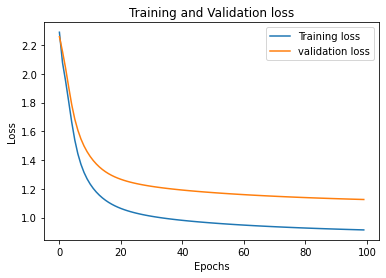

In [148]:
plt.plot(range(len(trainer.history['loss_train'])), trainer.history['loss_train'], label='Training loss')
plt.plot(range(len(trainer.history['loss_val'])), trainer.history['loss_val'], label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [149]:
def _predict_dataloader(self, dataloader: DataLoader, device):
  self.eval()
  y_pred_batch_list = []
  y_true_batch_list=[]
  for x, y in dataloader:
    x = x.to(device)
    out = model(x.to(torch.float))
    out_prob = out['pred']
    y_pred_batch = out_prob.argmax(axis=1)
    y_pred_batch_list.append(y_pred_batch)
    y_true_batch_list.append(y)
  y_pred = torch.cat(y_pred_batch_list, axis=0)
  y_true = torch.cat(y_true_batch_list, axis=0)

  return {'y_true': y_true, 'y_pred': y_pred}

In [157]:
res = _predict_dataloader(model, val_dataloader, 'cuda')
y_true = res['y_true'].cpu()
y_pred = res['y_pred'].cpu()

In [158]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.739333722969024

In [162]:
def _predict_one_sample(model, x, device):
  model.eval()
  x = x.to(torch.float)
  x = x.to(device)
  batched_x = x.unsqueeze(0)
  out = model(batched_x)

  # here it gets a bit tricky, let's extract the predicted probability distribution
  pred = out['pred']

  # first of all, since we are mocking the batching behavior, let's just take the first
  pred = pred[0]

  # now, pred stores a probability distribution, assigning a probability p to each possible number of stars
  # in order to extract the "actual prediction", we can simply select the one with the highest probability
  pred = pred.argmax()
  return pred.item()

In [159]:
def complete_prediction_pipeline(model, file_in_path, file_out_path):
  file_in = open(file_in_path, 'r')
  file_out = open(file_out_path, 'w')
  for line in file_in:
    loaded = fileline_to_sample(line)
    x =torch.Tensor(loaded['x'])
    y_pred = _predict_one_sample(model, x, 'cuda')
    y_pred_label = tensor_to_label(torch.tensor(y_pred))
    file_out.write(str(loaded['id']) + '\t' + y_pred_label + '\n')

  file_out.close()
  file_in.close()

In [163]:
FILE_IN = FILE_VAL
FILE_OUT = os.path.join(DIR_PWD, 'predictions_val.tsv')
complete_prediction_pipeline(model, FILE_IN, FILE_OUT)

skipped number: 55½


In [164]:
FILE_IN = FILE_TEST
FILE_OUT = os.path.join(DIR_PWD, 'predictions_test.tsv')
complete_prediction_pipeline(model, FILE_IN, FILE_OUT)

skipped number: 2½
skipped number: ½


In [165]:
drive.flush_and_unmount() 